## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [60]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [61]:
df= pd.read_csv('ab_data.csv')
df.head()

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

b. Use the below cell to find the number of rows in the dataset.

In [62]:
df.shape 

(294478, 5)

c. The number of unique users in the dataset.

In [63]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [64]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [65]:
df2 = df.query("(group == 'control' and landing_page == 'new_page') or (group == 'treatment' and landing_page == 'old_page')") 
df2.shape[0]

3893

f. Do any of the rows have missing values?

In [66]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [67]:
df2 = df.query("(group == 'control' and landing_page == 'old_page') or (group == 'treatment' and landing_page == 'new_page')")

In [68]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [69]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [70]:
df2[df2.duplicated(['user_id'])]['user_id'].unique()

array([773192])

c. What is the row information for the repeat **user_id**? 

In [71]:
df2[df2.duplicated(['user_id'], keep=False)]

user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [72]:
df2 = df2.drop_duplicates(['user_id'], keep='first')

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [73]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [74]:
df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [75]:
df2[df2['group'] == 'treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [76]:
len(df2.query("landing_page == 'new_page'")) / df2.shape[0]

0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**The previous result shows that the control group is higher conversion rate (0.1204) than the treatment group (0.1195), therefore I cannot conclude that the new treatment page leads to more conversions**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.


**Null-hypothesis**
>$H_0 : p_{new} - p_{old} \leq 0$


**Alternative-hypothesis**
>$H_1 : p_{new} - p_{old} \gt 0$



`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [77]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [78]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [79]:
n_new = df2[df2['group'] == 'treatment'].shape[0]
n_new

145310

d. What is $n_{old}$?

In [80]:
n_old = df2[df2['group'] == 'control'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [81]:
new_page_converted = np.random.binomial(n_new,p_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [82]:
old_page_converted = np.random.binomial(n_old,p_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [83]:
new_page_converted/n_new - old_page_converted/n_old

0.0004453115431042737

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [84]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new,p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    diff = new_page_converted/n_new - old_page_converted/n_old
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([   2.,    6.,   15.,   33.,   63.,  132.,  229.,  341.,  575.,
         793.,  993., 1141., 1123., 1105., 1005.,  822.,  599.,  428.,
         277.,  169.,   92.,   34.,    8.,    9.,    6.]),
 array([-0.00453754, -0.0041802 , -0.00382286, -0.00346552, -0.00310817,
        -0.00275083, -0.00239349, -0.00203615, -0.0016788 , -0.00132146,
        -0.00096412, -0.00060678, -0.00024943,  0.00010791,  0.00046525,
         0.00082259,  0.00117993,  0.00153728,  0.00189462,  0.00225196,
         0.0026093 ,  0.00296665,  0.00332399,  0.00368133,  0.00403867,
         0.00439602]),
 <a list of 25 Patch objects>)

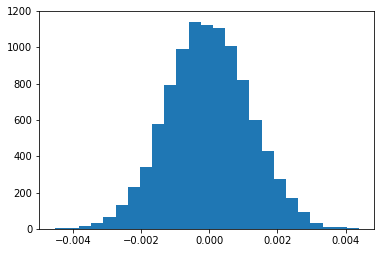

In [85]:
plt.hist(p_diffs, bins=25)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [86]:
act_diff = df2[df2['group'] == 'treatment']['converted'].mean() -  df2[df2['group'] == 'control']['converted'].mean()
print(act_diff)
p_diffs = np.array(p_diffs)
(act_diff < p_diffs).mean()

-0.0015782389853555567


0.9062

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**In scientific studies this value called P-value. The definition of a p-value is the probability of observing your statistic (or one more extreme in favor of the alternative) if the null hypothesis is true.**


**In the previous part, the p-value is high. Therefore, the null hypothesis is true as old and new pages perform almost similarly. Old pages. The P values means more extreme in favor of the the alternative if the null hypothesis is true,but here P value equal 0.9027 is larger than 0.05 we would fail to reject the null hypothesis and would not accept the alternative hypothesis.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [87]:
import statsmodels.api as sm

convert_old =  df2.query('landing_page=="old_page" and converted==1').count()[0]
convert_new = df2.query('landing_page=="new_page" and converted==1').count()[0]
n_old = df2.query('landing_page=="old_page"').count()[0]
n_new = df2.query('landing_page=="new_page"').count()[0]
print(convert_old)
print(n_old)
print(convert_new)
print(n_new)

17489
145274
17264
145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [88]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new,n_old], alternative='larger')
print(p_value)
print(z_score)

0.9050583127590245
-1.3109241984234394


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score is the number of standard deviation a data-point is from the population mean. It is greater than the value of -0.1645 (one-tail test) and hence it suggests that we can't reject the null. The p-value determines the significance of the resuls. The values are different from parts j and k but there is no statistically significant difference betweem the new and the old page.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [89]:
df2['intercept']=1
df2[['control', 'ab_page']]=pd.get_dummies(df2['group'])
df2.drop(labels=['control'], axis=1, inplace=True)
df2.head()

user_id                   timestamp      group landing_page  converted  \
0   851104  2017-01-21 22:11:48.556739    control     old_page          0   
1   804228  2017-01-12 08:01:45.159739    control     old_page          0   
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
4   864975  2017-01-21 01:52:26.210827    control     old_page          1   

   intercept  ab_page  
0          1        0  
1          1        0  
2          1        1  
3          1        1  
4          1        0

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [90]:
import statsmodels.api as sm

mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = mod.fit() 

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [91]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 16 Jan 2019   Pseudo R-squ.:               8.077e-06
Time:                        21:48:51   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The p-value associated with ab_page is 0.19. It is higher than 0.05. Thus, the coefficient is not significant**

**Alternative hypothesis from part II:the conversion rate of the new_page is higher than the conversion rate of the old_page.**

**Alternative hypothesis from part III: The landing_page type influences the conversion rate, or the conversion rate of the old_page is different to the conversion rate of the new_page. This assumes a two-tailed test.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**It is a good idea to consider other factors in order to identify other potencial influences on the conversion rate. The other factor can be the time or  the converted rate depends on certain time.**

**The disadvantages to adding additional terms into the regression model is that the model will be more complicated.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [92]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

country                   timestamp      group landing_page  \
user_id                                                               
834778       UK  2017-01-14 23:08:43.304998    control     old_page   
928468       US  2017-01-23 14:44:16.387854  treatment     new_page   
822059       UK  2017-01-16 14:04:14.719771  treatment     new_page   
711597       UK  2017-01-22 03:14:24.763511    control     old_page   
710616       UK  2017-01-16 13:14:44.000513  treatment     new_page   

         converted  intercept  ab_page  
user_id                                 
834778           0          1        0  
928468           0          1        1  
822059           1          1        1  
711597           0          1        0  
710616           0          1        1

In [93]:
##unique countries
countries_df['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [94]:
df_new[['CA','US','UK']] = pd.get_dummies(df_new['country'])[['CA','US','UK']]
df_new.tail()

country                   timestamp      group landing_page  \
user_id                                                               
653118       US  2017-01-09 03:12:31.034796    control     old_page   
878226       UK  2017-01-05 15:02:50.334962    control     old_page   
799368       UK  2017-01-09 18:07:34.253935    control     old_page   
655535       CA  2017-01-09 13:30:47.524512  treatment     new_page   
934996       UK  2017-01-09 00:30:08.377677    control     old_page   

         converted  intercept  ab_page  CA  US  UK  
user_id                                             
653118           0          1        0   0   1   0  
878226           0          1        0   0   0   1  
799368           0          1        0   0   0   1  
655535           0          1        1   1   0   0  
934996           0          1        0   0   0   1

In [95]:
log_mod_countries = sm.Logit(df_new['converted'],df_new[['intercept','US','UK']])
results_countries = log_mod_countries.fit()
results_countries.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 16 Jan 2019   Pseudo R-squ.:               1.521e-05
Time:                        21:48:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US             0.0408      0.027      1.518      0.129      -0.012       0.093
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
==============================================================================
"""

In [96]:
# Adding ab_page
log_mod_countries_2 = sm.Logit(df_new['converted'],df_new[['intercept','US','UK','ab_page']])
results_countries_2 = log_mod_countries_2.fit()
results_countries_2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 16 Jan 2019   Pseudo R-squ.:               2.323e-05
Time:                        21:48:58   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [97]:

df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']
df_new['UK_ab_page'] = df_new['UK'] * df_new['ab_page']
df_new.head()

country                   timestamp      group landing_page  \
user_id                                                               
834778       UK  2017-01-14 23:08:43.304998    control     old_page   
928468       US  2017-01-23 14:44:16.387854  treatment     new_page   
822059       UK  2017-01-16 14:04:14.719771  treatment     new_page   
711597       UK  2017-01-22 03:14:24.763511    control     old_page   
710616       UK  2017-01-16 13:14:44.000513  treatment     new_page   

         converted  intercept  ab_page  CA  US  UK  US_ab_page  UK_ab_page  
user_id                                                                     
834778           0          1        0   0   0   1           0           0  
928468           0          1        1   0   1   0           1           0  
822059           1          1        1   0   0   1           0           1  
711597           0          1        0   0   0   1           0           0  
710616           0          1        1   0   0   1           0           1

In [98]:
log_mod_int = sm.Logit(df_new['converted'],df_new[['intercept','US','UK','ab_page','US_ab_page','UK_ab_page']])
results_int = log_mod_int.fit()
results_int.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 16 Jan 2019   Pseudo R-squ.:               3.482e-05
Time:                        21:49:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US_ab_page     0.0469      0.054      0.872      0.383      -0.059       0.152
UK_ab_page     0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

**Result: p-value is still higher than alpha, fail to reject null**

**The z-score for the intercept is large.**

<a id='conclusions'></a>
## Finishing Up

## Conclusion:

**The p_value for both interaction terms is higher than 0.05 and the influence of landing_page in the US and CA is not different to the influence of landing_page in the other countries. The variables don't  have significant p-values. From the results, there is no significant impact of the countries and new page on conversion rates. Comparing users among different countries also doesn't show considerable difference in statistics. **
**Based on the analysis, there is no practical significance in rolling out the new page over old page. Conversion rate for old page is better than new one.**
**I think that we shouldn't implement this new page as there is no conclusive evidence that it is better than the old page.**


In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])